# Notebook 3b: *Probabilistic Programming*: a *tutorial-example*

Probabilistic Machine Learning -- Spring 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/probml-units/blob/main/notebooks/03b_probabilistic_programming.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

The *tutorial-example* that follows is an adaptation of the official `Pyro` tutorials on *Bayesian Regression*: [part 1](https://pyro.ai/examples/bayesian_regression.html) and [part 2](https://pyro.ai/examples/bayesian_regression_ii.html). The overall scope remains the same, but emphasis in the following will be put on interactive execution and in-class commentary: this will allow us to overview the essential steps of **modelling** and **inference** in `Pyro`, and clarify some possible idiosyncratic behaviours.

In [3]:
# For type annotations
from typing import Optional

# For good-looking progress bars
from tqdm.auto import tqdm, trange

# The usual NumFocus stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
from torch import nn
from torch.distributions import constraints

# Pyro
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive, SVI, Trace_ELBO, MCMC, NUTS
from pyro.infer.autoguide import (
    AutoDiagonalNormal,
    AutoMultivariateNormal,
    init_to_mean,
)

### Overview

The example that follows tries to replicate - and extend in the Bayesian sense - some of the analyses performed by Nathan Nunn and Diego Puga in their 2010 paper [*Ruggedness: The Blessing of Bad Geography in Africa*](https://scholar.harvard.edu/sites/scholar.harvard.edu/files/nunn/files/ruggedness.pdf).

The authors of the paper are interested in understanding the relationship between geography and economic development in Africa. In particular, they are interested in the effect of *ruggedness* - a measure of topographical dishomogeneity of a country - on the level of economic development. To this end, they collect data on *ruggedness* and *GDP per capita* of some countries (from within and outside Africa). Then they fit a linear regression model to the data, with explanatory aims.

The conclusions of the paper are that *ruggedness* is - in general - negatively correlated with *GDP per capita*, but in Africa the opposit holds due to the historical effects of *ruggeredness* on discouraging and limiting colonialistic slave capture and trade. Such effect exerted a positive impact on the development of African economies established within *rugged* terrain areas, measurable even today.

In [4]:
rugg_data = pd.read_csv(
    "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv",
    encoding="ISO-8859-1",
)
df = rugg_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

Our dataframe now only contains, for each country:
- `cont_africa`: a binary variable indicating whether the country is in Africa or not;
- `rgdppc_2000`: the *log-GDP* per capita of the country in 2000, in 2000 international dollars;
- `rugged`: the *ruggedness* index of the country, averaged over the whole territory.

In [5]:
# Some string-shorthands for often-occuring names
tridx = "Terrain Ruggedness Index"
logdp2000 = "log-GDP (2000)"
afrnat = "African Nations"
nafrnat = "Non-African Nations"
svidn = "SVI (Diagonal Normal Guide)"
svimn = "SVI (Multivariate Normal Guide)"

#### A plot of the data

Code details can be skipped...

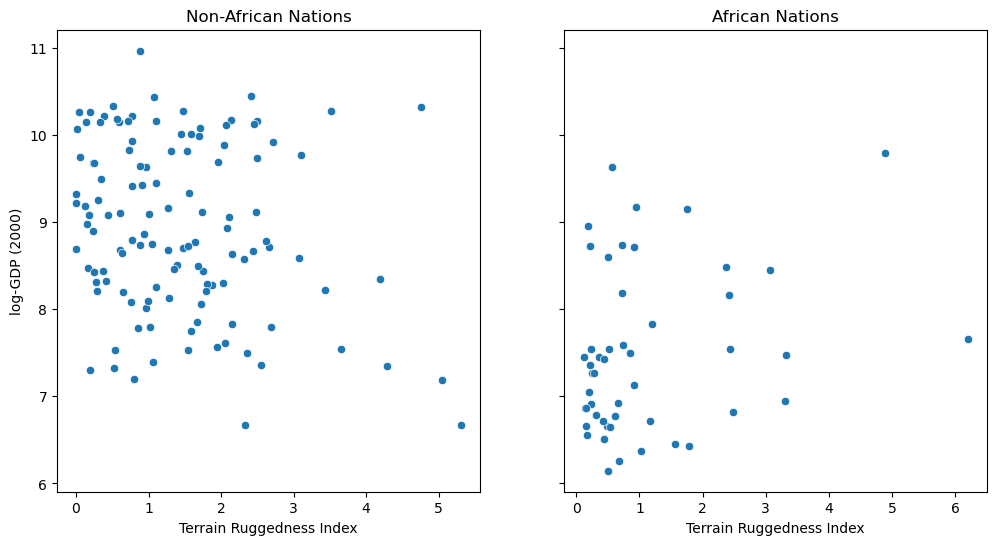

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]

sns.scatterplot(
    x=non_african_nations["rugged"], y=non_african_nations["rgdppc_2000"], ax=ax[0]
)
_ = ax[0].set(
    xlabel=tridx,
    ylabel=logdp2000,
    title=nafrnat,
)

sns.scatterplot(x=african_nations["rugged"], y=african_nations["rgdppc_2000"], ax=ax[1])
_ = ax[1].set(xlabel=tridx, ylabel=logdp2000, title=afrnat)

### Linear regression in pure `PyTorch`

**Note:** the target variable is the *log-GDP per capita*, to be described in terms of ruggedness, belonigng to the African Continent, and interaction between the two!

In [7]:
# Add a feature to the DataFrame capturing the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]

data = torch.tensor(
    df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
    dtype=torch.float,
)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model: weights are (just) a 3x1 matrix (+ 1x1 bias)
# The Module1[Module2] syntax defines a Module1/Module2 mixin class
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define the loss and optimize weights w.r.t. it
loss_fn = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 3000


def train_step():
    # Forward run of the model
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # Loss evaluation (from random weights)
    loss = loss_fn(y_pred, y_data)
    # Reset gradient accumulation
    optimizer.zero_grad()
    # Gradient computation (by BackProp)
    loss.backward()
    # Optimization in the loss descent direction (in weight space)
    optimizer.step()
    return loss


# Just repeat that a few times...
for j in trange(num_iterations):
    loss = train_step()
    if (j + 1) % 50 == 0:
        print(f"[iteration {j+1:04d}] loss: {loss.item():.4f}")


# Inspect learned parameters
print("\nLearned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

  0%|          | 0/3000 [00:00<?, ?it/s]

[iteration 0050] loss: 3160.1492
[iteration 0100] loss: 1777.8887
[iteration 0150] loss: 1235.0916
[iteration 0200] loss: 904.6690
[iteration 0250] loss: 664.9828
[iteration 0300] loss: 487.7877
[iteration 0350] loss: 362.1882
[iteration 0400] loss: 277.5300
[iteration 0450] loss: 223.1768
[iteration 0500] loss: 189.8723
[iteration 0550] loss: 170.3703
[iteration 0600] loss: 159.4474
[iteration 0650] loss: 153.5927
[iteration 0700] loss: 150.5884
[iteration 0750] loss: 149.1126
[iteration 0800] loss: 148.4185
[iteration 0850] loss: 148.1060
[iteration 0900] loss: 147.9714
[iteration 0950] loss: 147.9160
[iteration 1000] loss: 147.8941
[iteration 1050] loss: 147.8860
[iteration 1100] loss: 147.8830
[iteration 1150] loss: 147.8820
[iteration 1200] loss: 147.8817
[iteration 1250] loss: 147.8816
[iteration 1300] loss: 147.8815
[iteration 1350] loss: 147.8815
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
[iteration 1550] loss: 147.8815
[iter

#### A plot of the data, with overlay regression line(s)

Code details can be skipped...

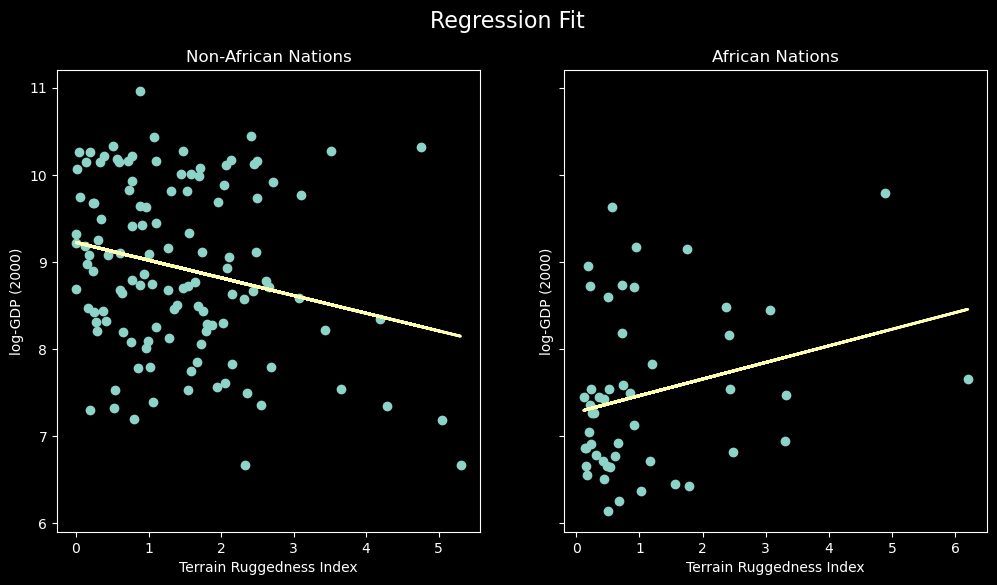

In [8]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
_ = ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
_ = ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
_ = ax[0].set(
    xlabel=tridx,
    ylabel=logdp2000,
    title=nafrnat,
)
_ = ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
_ = ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
_ = ax[1].set(xlabel=tridx, ylabel=logdp2000, title=afrnat)

### Bayesian Linear Regression in `Pyro` (*SVI* inference with `AutoGuide`)

Choose a family of functions, and model what I observe with that family. So by design solution is in that model. 
In variational inference we tune the parameters of the distributions iteratively to obtain the closest approximation to the data.

We evaluate the gof by comparing the (empirical) KL divergence between our family with varying parameters and the observed data. 

In Pyro you have many different ways to sample from distributions.
In this case we want to sample the weights of our regression matrix from a standard distribution:
    `dist.Normal(0.0, 1.0).expand([out_features, in_features])`
The argument of the expand operations is the tuple of the dimension of the tensor we want to sample, i.e. the out_feat $\times$ in_features, independent and identically distributed.

In our case the `to_event(2)` makes sure that the operations we consider for inference that it is same dimension of the tensors. This is necessary because we may have a batch of matrices which may correspond to different networks but are independent among each other, so we have to specify batch size and out_features, in_features.

Same for the bias, we put a normal prior, here `to_event(1)` cause the bias is a one dimensional object.

The `forward` method is a way to obtain the prediction.

In [9]:
# A PyroModule is (just) a PyTorch Module with support for Pyro primitives
class BayesianRegression(PyroModule): # Derived class of PyroModule
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        # We input a matrix of inputs of dimension in_feature and want an out_feature 
        # (I presume in features is p and y features is how many outputs we want, suppose we want classification of 3 classes we output 3 probabilities)
        self.linear = PyroModule[nn.Linear](in_features, out_features)

        # ... but now we put priors on weights/bias
        self.linear.weight = PyroSample( # PyroSample means we can sample from this.
            # we put as prior a standard normal, must be optimized indep for out_features and in_features 
            # 
            dist.Normal(0.0, 1.0).expand([out_features, in_features]).to_event(2)  # Sample a tensor of size specified inside the expand function
                                                                                   # to_event(2) means that for the last 2 dimensions given in expan we want to obtain all samples at once (same conceptual object). 
                                                                                   # see the example of batches provided above to understand this
        )
        self.linear.bias = PyroSample(
            dist.Normal(0.0, 10.0).expand([out_features]).to_event(1) # bias parameter is w0 i.e. the intercept coefficient.
        )

    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None):
        sigma = pyro.sample("sigma", dist.Uniform(0.0, 10.0)) # data variance
        mean = self.linear(x).squeeze(-1)                     # data mean is computed from the linear model we have defined before.

        with pyro.plate("data", x.shape[0]): # within a plate of shape x.shape[0], i.e. how many data points we have in x
            # Data are conditionally independent given the parameters
            # Sample some obs with mean mean and sigma sigma.
            # If y is passed, yse that y as the observations on which to condition for the sampling of the parameters.
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y) #If I pass a torch tensor, condition on y, otherwise do NOT condition.

        return mean  # This is the log-GDP "prediction"

In [10]:
model = BayesianRegression(3, 1)

# SVI: optimization approach to approximate inference
# Variational family: a diagonal normal distribution
#
# Note: the resulting model will belong to this family, by definition.
#       If expressiveness is an issue, we should use a more expressive family!
#
guide = AutoDiagonalNormal(model) # parametric family of functions we want the solution to be in.

optimizer = pyro.optim.Adam({"lr": 0.03}) #option for optimizer, choose the ones you want.
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [11]:
# VERY IMPORTANT: clear the parameter store before running *EACH* inference loop!
# If you want to dig deeper into what the parameter store is, check out:
# https://docs.pyro.ai/en/stable/parameters.html#module-pyro.params.param_store
pyro.clear_param_store()

for j in trange(num_iterations):
    # Loss calculation + gradient zeroing + gradient computation + weight update
    # as a shorthand for SVI.
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print(f"[iteration {j+1:04d}] loss: {loss / len(data):.4f}")

  0%|          | 0/3000 [00:00<?, ?it/s]

[iteration 0001] loss: 4.4668
[iteration 0101] loss: 3.2388
[iteration 0201] loss: 2.8383
[iteration 0301] loss: 2.4002
[iteration 0401] loss: 1.5263
[iteration 0501] loss: 1.4678
[iteration 0601] loss: 1.4446
[iteration 0701] loss: 1.4359
[iteration 0801] loss: 1.4708
[iteration 0901] loss: 1.4682
[iteration 1001] loss: 1.4591
[iteration 1101] loss: 1.4634
[iteration 1201] loss: 1.4821
[iteration 1301] loss: 1.4673
[iteration 1401] loss: 1.4575
[iteration 1501] loss: 1.4556
[iteration 1601] loss: 1.4798
[iteration 1701] loss: 1.4634
[iteration 1801] loss: 1.4592
[iteration 1901] loss: 1.4519
[iteration 2001] loss: 1.4621
[iteration 2101] loss: 1.5151
[iteration 2201] loss: 1.4534
[iteration 2301] loss: 1.4765
[iteration 2401] loss: 1.4563
[iteration 2501] loss: 1.5001
[iteration 2601] loss: 1.4625
[iteration 2701] loss: 1.4647
[iteration 2801] loss: 1.4687
[iteration 2901] loss: 1.4776


In [12]:
guide.requires_grad_(False)

# Inspection of learned parameters (means, averages!)
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2503, -1.8513, -0.2018,  0.3316,  9.1720])
AutoDiagonalNormal.scale tensor([0.0722, 0.1151, 0.0402, 0.0670, 0.0688])


In [13]:
# But also: quantiles!
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.9121, 0.9532, 0.9961]),
 'linear.weight': tensor([[[-1.9289, -0.2289,  0.2865]],
 
         [[-1.8513, -0.2018,  0.3316]],
 
         [[-1.7736, -0.1747,  0.3768]]]),
 'linear.bias': tensor([[9.1256],
         [9.1720],
         [9.2185]])}

In [14]:
# Utility function
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


# Sampling from the Posterior Predictive Distribution
predictive = Predictive(
    model,
    guide=guide,
    num_samples=800,
    # Where we want to collect samples from.
    # "_RETURN" is a special placeholder that indicates the return value of the model
    # (in our case: the mean, the log-GDP per capita).
    return_sites=("linear.weight", "obs", "_RETURN"),
)

samples = predictive(x_data)
pred_summary = summary(samples)

#### A plot of the data, with overlay regression line(s) and respective *C.I*.s

Code details can be skipped...

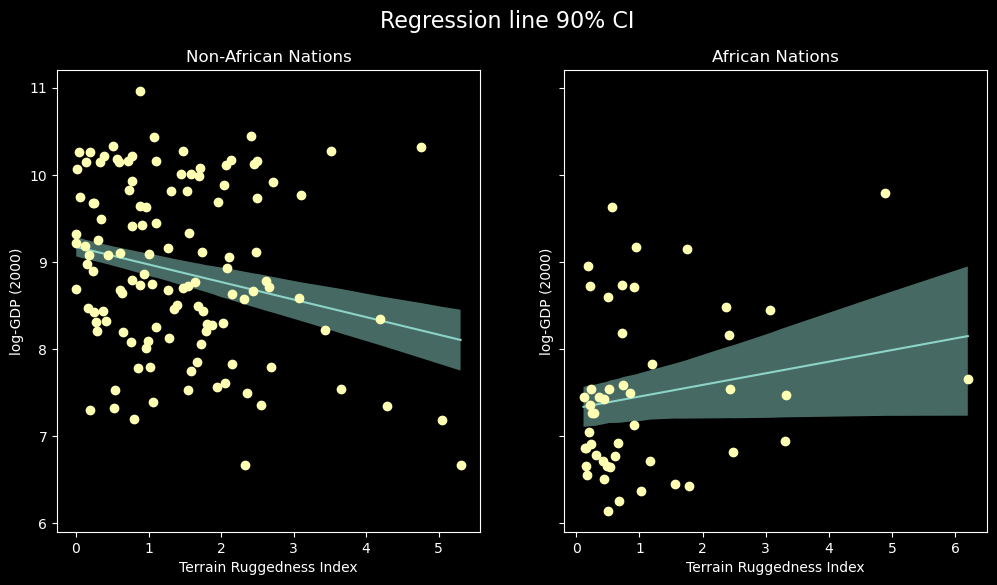

In [15]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame(
    {
        "cont_africa": x_data[:, 0],
        "rugged": x_data[:, 1],
        "mu_mean": mu["mean"],
        "mu_perc_5": mu["5%"],
        "mu_perc_95": mu["95%"],
        "y_mean": y["mean"],
        "y_perc_5": y["5%"],
        "y_perc_95": y["95%"],
        "true_gdp": y_data,
    }
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["mu_mean"])
ax[0].fill_between(
    non_african_nations["rugged"],
    non_african_nations["mu_perc_5"],
    non_african_nations["mu_perc_95"],
    alpha=0.5,
)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(
    xlabel=tridx,
    ylabel=logdp2000,
    title=nafrnat,
)
idx = np.argsort(african_nations["rugged"])
_ = ax[1].plot(african_nations["rugged"], african_nations["mu_mean"])
_ = ax[1].fill_between(
    african_nations["rugged"],
    african_nations["mu_perc_5"],
    african_nations["mu_perc_95"],
    alpha=0.5,
)
_ = ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
_ = ax[1].set(xlabel=tridx, ylabel=logdp2000, title=afrnat)

#### A plot of the data, with overlay *PPD* *C.I*.s

Code details can be skipped...

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution 90% CI", fontsize=16)
_ = ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
_ = ax[0].fill_between(
    non_african_nations["rugged"],
    non_african_nations["y_perc_5"],
    non_african_nations["y_perc_95"],
    alpha=0.5,
)
_ = ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
_ = ax[0].set(
    xlabel=tridx,
    ylabel=logdp2000,
    title=nafrnat,
)
idx = np.argsort(african_nations["rugged"])

_ = ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
_ = ax[1].fill_between(
    african_nations["rugged"],
    african_nations["y_perc_5"],
    african_nations["y_perc_95"],
    alpha=0.5,
)
_ = ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
_ = ax[1].set(xlabel=tridx, ylabel=logdp2000, title=afrnat)

#### A plot of the *pdf* of the slope term, and overlay *KDE*

Code details can be skipped...

In [ ]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa, kde=True, label=afrnat)
sns.histplot(gamma_outside_africa, kde=True, label=nafrnat)
_ = fig.suptitle("Density of Slope: log(GDP) vs. Terrain Ruggedness")
_ = plt.legend()

### Bayesian Linear Regression in `Pyro` (*SVI* inference with manual guide)

In [ ]:
# The same model as before, as a function. This allows finer control over the generative process.
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0.0, 10.0))
    b_a = pyro.sample("bA", dist.Normal(0.0, 1.0))
    b_r = pyro.sample("bR", dist.Normal(0.0, 1.0))
    b_ar = pyro.sample("bAR", dist.Normal(0.0, 1.0))
    sigma = pyro.sample("sigma", dist.Uniform(0.0, 10.0))
    mean = (
        a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    )
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)


# A "guide" for SVI, detailing the variational family of choice.
# In general, it should have the same agruments as the model.
# Model: PRIORS over the true model parameters; Guide: APPROXIMANT definition
#        (`pyro.params` will be optimized)
def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param("a_loc", torch.tensor(0.0))
    a_scale = pyro.param("a_scale", torch.tensor(1.0), constraint=constraints.positive)
    sigma_loc = pyro.param(
        "sigma_loc", torch.tensor(1.0), constraint=constraints.positive
    )
    weights_loc = pyro.param("weights_loc", torch.randn(3))
    weights_scale = pyro.param(
        "weights_scale", torch.ones(3), constraint=constraints.positive
    )
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = (
        a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    )
    _ = log_gdp  # Dummy argument

In [ ]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(
            percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]
        ).transpose()
        site_stats[site_name] = describe[
            ["mean", "std", "5%", "25%", "50%", "75%", "95%"]
        ]
    return site_stats

In [ ]:
# Prepare training data
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [ ]:
# Exactly the same as before, but with a custom guide!

svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.05}), loss=Trace_ELBO())

pyro.clear_param_store()

num_iters = 5000
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        print(f"Elbo loss: {elbo}")

In [ ]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {
    k: v.reshape(num_samples).detach().cpu().numpy()
    for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
    if k != "obs"
}

In [ ]:
# Parameter inspection
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

### Bayesian Linear Regression in `Pyro` (*NUTS* inference)

- More accurate than *SVI* (potentially exact; accuracy generally $\propto$ running time);
- No guide required;

${~}$
- Slower than *SVI*;
- Potentially harder to make converge;
- Potentially intractable in the (very, very) high-dimensional limit.

In [ ]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [ ]:
# Inspection of the parameters
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

#### Some comparative plots...
Code details can be skipped...

In [ ]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(svi_samples[site], ax=ax, label=svidn, kde=True)
    sns.histplot(hmc_samples[site], ax=ax, label="HMC", kde=True)
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
_ = fig.legend(handles, labels, loc="upper right")

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], fill=True, label="HMC")
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], label=svidn)
_ = axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(
    x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], fill=True, label="HMC"
)
sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1], label=svidn)
_ = axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))

### What we did with a manual *guide* can also be done automatically... 🙃

In [ ]:
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        print(f"Elbo loss: {elbo}")

#### Some (more) comparative plots...
Code details can be skipped...

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_mvn_samples = {
    k: v.reshape(num_samples).detach().cpu().numpy()
    for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
    if k != "obs"
}
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(svi_mvn_samples[site], ax=ax, label=svimn, kde=True)
    sns.histplot(hmc_samples[site], ax=ax, label="HMC", kde=True)
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
_ = fig.legend(handles, labels, loc="upper right")

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], label=svidn)
sns.kdeplot(
    x=svi_mvn_samples["bA"],
    y=svi_mvn_samples["bR"],
    ax=axs[0],
    fill=True,
    label=svimn,
)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1], label=svidn)
sns.kdeplot(
    x=svi_mvn_samples["bR"],
    y=svi_mvn_samples["bAR"],
    ax=axs[1],
    fill=True,
    label=svimn,
)
_ = axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], fill=True, label="HMC")
sns.kdeplot(
    x=svi_mvn_samples["bA"],
    y=svi_mvn_samples["bR"],
    ax=axs[0],
    label=svimn,
)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(
    x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], fill=True, label="HMC"
)
sns.kdeplot(
    x=svi_mvn_samples["bR"],
    y=svi_mvn_samples["bAR"],
    ax=axs[1],
    label=svimn,
)
_ = axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))

### That's a wrap! 🎉

And you thought *Bayesian modelling* was hard?

![](./img/bayes.jpg)
<br><sub><sup>A meme: from <a href="https://commons.wikimedia.org/wiki/File:ThomasBayes.png">Mark Riehl, Colorized version of a public domain portrait of Thomas Bayes, Wikipedia Commons, 2016</a>, meme-ified with <a href="https://imgflip.com">imgflip.com</a></sup></sub>.







